# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlenghts`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` libarary.  Here's an example:

In [7]:
training.get_word_Xlengths('WRITE')

(array([[-20,  27, -10, 102],
        [-16,  31,  -6,  92],
        [-12,  33,   0,  80],
        [ -8,  40,   2,  71],
        [ -3,  47,   6,  66],
        [ -2,  49,   9,  60],
        [ -7,  63,  10,  54],
        [-11,  60,  11,  55],
        [-12,  58,  10,  58],
        [-17,  55,  12,  57],
        [-17,  51,  11,  58],
        [-15,  49,   9,  58],
        [-11,  47,  10,  59],
        [ -5,  44,   8,  57],
        [ -3,  47,  10,  55],
        [  1,  53,   9,  55],
        [ -8,  54,   8,  56],
        [-12,  55,   8,  57],
        [-16,  52,  11,  59],
        [-21,  50,  11,  58],
        [-18,  45,  14,  57],
        [-17,  45,  11,  60],
        [-11,  45,  10,  60],
        [ -6,  49,   8,  58],
        [ -2,  55,  10,  57],
        [ -5,  59,   8,  59],
        [-13,  58,  12,  58],
        [-17,  55,  10,  61],
        [-26,  51,   7,  60]], dtype=int64), [29])

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

left-x      left-y     right-x     right-y      nose-x  \
speaker                                                               
man-1    206.248203  218.679449  155.464350  150.371031  175.031756   
woman-1  164.661438  161.271242  151.017865  117.332462  162.655120   
woman-2  183.214509  176.527232  156.866295  119.835714  170.318973   

            nose-y    grnd-ry    grnd-rx     grnd-ly    grnd-lx  
speaker                                                          
man-1    61.642600  88.728430 -19.567406  157.036848  31.216447  
woman-1  57.245098  60.087364 -11.637255  104.026144   2.006318  
woman-2  58.022098  61.813616 -13.452679  118.505134  12.895536

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


left-x     left-y    right-x    right-y    nose-x    nose-y  \
speaker                                                                   
man-1    15.154425  36.328485  18.901917  54.902340  6.654573  5.520045   
woman-1  17.573442  26.594521  16.459943  34.667787  3.549392  3.538330   
woman-2  15.388711  28.825025  14.890288  39.649111  4.099760  3.416167   

           grnd-ry    grnd-rx    grnd-ly    grnd-lx  left-x-mean  
speaker                                                           
man-1    53.487999  20.269032  36.572749  15.080360          0.0  
woman-1  33.972660  16.764706  27.117393  17.328941          0.0  
woman-2  39.128572  16.191324  29.320655  15.050938          0.0

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

#calculate indicators for further calculation
## calculate means
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])

# ## calculate std
asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])

## calculate Z-score
asl.df['norm-rx'] = (asl.df['right-x']- asl.df['right-x-mean'])/(asl.df['right-x-std'])
asl.df['norm-ry'] = (asl.df['right-y']- asl.df['right-y-mean'])/(asl.df['right-y-std'])

asl.df['norm-lx'] = (asl.df['left-x']- asl.df['left-x-mean'])/(asl.df['left-x-std'])
asl.df['norm-ly'] = (asl.df['left-y']- asl.df['left-y-mean'])/(asl.df['left-y-std'])



features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
asl.df['polar-rr'] = np.sqrt((asl.df['grnd-rx'])**2 + (asl.df['grnd-ry'])**2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])

asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])


features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx']= asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry']= asl.df['right-y'].diff().fillna(0)
asl.df['delta-lx']= asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly']= asl.df['left-y'].diff().fillna(0)


features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
#add features for normalized by speaker values of left, right, x, y using scaling min-max technique

#Find min-max values
df_max = asl.df.groupby('speaker').max()
df_min = asl.df.groupby('speaker').min()

asl.df['left-x-min']= asl.df['speaker'].map(df_min['left-x'])
asl.df['left-y-min']= asl.df['speaker'].map(df_min['left-y'])
asl.df['right-x-min']= asl.df['speaker'].map(df_min['right-x'])
asl.df['right-y-min']= asl.df['speaker'].map(df_min['right-y'])

asl.df['left-x-max']= asl.df['speaker'].map(df_max['left-x'])
asl.df['left-y-max']= asl.df['speaker'].map(df_max['left-y'])
asl.df['right-x-max']= asl.df['speaker'].map(df_max['right-x'])
asl.df['right-y-max']= asl.df['speaker'].map(df_max['right-y'])


## calculate feature scaled values
asl.df['norm2-rx'] = (asl.df['right-x']- asl.df['right-x-min'])/(asl.df['right-x-max']-asl.df['right-x-min'])
asl.df['norm2-ry'] = (asl.df['right-y']- asl.df['right-y-min'])/(asl.df['right-y-max']-asl.df['right-y-min'])

asl.df['norm2-lx'] = (asl.df['left-x']- asl.df['left-x-min'])/(asl.df['left-x-max']-asl.df['left-x-min'])
asl.df['norm2-ly'] = (asl.df['left-y']- asl.df['left-y-min'])/(asl.df['left-y-max']-asl.df['left-y-min'])



# TODO define a list named 'features_custom' for building the training set
features_custom = ['norm2-rx', 'norm2-ry', 'norm2-lx','norm2-ly']

In [34]:
#normalize polar coordinates using Z-score scaling (X-Xmean)/Xstd

#calculate indicators for further calculation

#recalculate means and std to include polar indicators
df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

## calculate means
asl.df['polar-lr-mean']= asl.df['speaker'].map(df_means['polar-lr'])
asl.df['polar-ltheta-mean']= asl.df['speaker'].map(df_means['polar-ltheta'])
asl.df['polar-rr-mean']= asl.df['speaker'].map(df_means['polar-rr'])
asl.df['polar-rtheta-mean']= asl.df['speaker'].map(df_means['polar-rtheta'])

# ## calculate std
asl.df['polar-lr-std']= asl.df['speaker'].map(df_std['polar-lr'])
asl.df['polar-ltheta-std']= asl.df['speaker'].map(df_std['polar-ltheta'])
asl.df['polar-rr-std']= asl.df['speaker'].map(df_std['polar-rr'])
asl.df['polar-rtheta-std']= asl.df['speaker'].map(df_std['polar-rtheta'])

## calculate Z-score
asl.df['norm-polar-rr'] = (asl.df['polar-rr']- asl.df['polar-rr-mean'])/(asl.df['polar-rr-std'])
asl.df['norm-polar-rtheta'] = (asl.df['polar-rtheta']- asl.df['polar-rtheta-mean'])/(asl.df['polar-rtheta-std'])

asl.df['norm-polar-lr'] = (asl.df['polar-lr']- asl.df['polar-lr-mean'])/(asl.df['polar-lr-std'])
asl.df['norm-polar-ltheta'] = (asl.df['polar-ltheta']- asl.df['polar-ltheta-mean'])/(asl.df['polar-ltheta-std'])



features_custom2 = ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr','norm-polar-ltheta']

In [37]:
#normalize polar coordinates using scaling min-max technique

#Find min-max values
df_max = asl.df.groupby('speaker').max()
df_min = asl.df.groupby('speaker').min()

asl.df['polar-lr-min']= asl.df['speaker'].map(df_min['polar-lr'])
asl.df['polar-ltheta-min']= asl.df['speaker'].map(df_min['polar-ltheta'])
asl.df['polar-rr-min']= asl.df['speaker'].map(df_min['polar-rr'])
asl.df['polar-rtheta-min']= asl.df['speaker'].map(df_min['polar-rtheta'])

asl.df['polar-lr-max']= asl.df['speaker'].map(df_max['polar-lr'])
asl.df['polar-ltheta-max']= asl.df['speaker'].map(df_max['polar-ltheta'])
asl.df['polar-rr-max']= asl.df['speaker'].map(df_max['polar-rr'])
asl.df['polar-rtheta-max']= asl.df['speaker'].map(df_max['polar-rtheta'])


## calculate feature scaled values
asl.df['norm2-polar-rr'] = (asl.df['polar-rr']- asl.df['polar-rr-min'])/(asl.df['polar-rr-max']-asl.df['polar-rr-min'])
asl.df['norm2-polar-rtheta'] = (asl.df['polar-rtheta']- asl.df['polar-rtheta-min'])/(asl.df['polar-rtheta-max']-asl.df['polar-rtheta-min'])

asl.df['norm2-polar-lr'] = (asl.df['polar-lr']- asl.df['polar-lr-min'])/(asl.df['polar-lr-max']-asl.df['polar-lr-min'])
asl.df['norm2-polar-ltheta'] = (asl.df['polar-ltheta']- asl.df['polar-ltheta-min'])/(asl.df['polar-ltheta-max']-asl.df['polar-ltheta-min'])



# TODO define a list named 'features_custom' for building the training set
features_custom3 = ['norm2-polar-rr', 'norm2-polar-rtheta', 'norm2-polar-lr','norm2-polar-ltheta']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** 
1. For the first experement I selected to try classical scaling techiques with min-max (X-X_min)/(X_max-X_min). I try it because in my practical experience in machine learning this data pre-processing techique performed better than Z_score. The best is log scaling but in this case it is inapplicable due to possible negative values in data
2. Later, when I did other excercises, I realized that this transformation technique performs better than Z-scaling
3. The best results provides polar coordinates transformation and I decided to normalize it with Z-score and classical scaling (features_custom2 and features_custom3 sets). While polar with Z-score didnt improve results (comparing with classical polar), scaled polar coordinates performed better: the best results with BIC remained the same (87 right answers), but scaled polar with DIC raised to 86 right answers.   

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [15]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.023s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log liklihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [16]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433223


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log liklihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [17]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #1
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [18]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [ -4.93681705  64.73171915   1.62598519  84.91459657]
variance =  [  6.1617479   28.36616959   5.47102461  13.11696032]

hidden state #1
mean =  [   0.58333258   87.91666611   12.75000001  108.49999882]
variance =  [  39.4105671    18.74389523    9.85499958  144.41752618]

hidden state #2
mean =  [ -9.23835975  55.307463     6.92298661  71.30538347]
variance =  [ 16.30887738  45.97071639   3.76856896  15.98215464]

hidden state #3
mean =  [  -6.37712306   51.09867416    3.64009161  104.46268173]
variance =  [  10.28220014   12.44316166   27.33390004  106.91029392]

logL = -565.1243334331177


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [19]:
%matplotlib inline

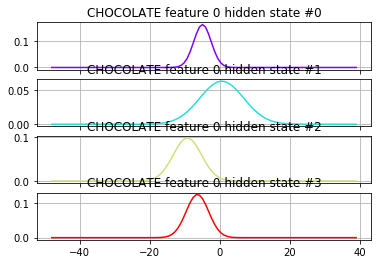

In [20]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `SelectorModel` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log liklihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [21]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Liklihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher liklihoods. However, that doesn't tell us which would have a better liklihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [22]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation

The advantages of scoring model topologies with **DIC** over BIC is presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf).  DIC scores the discriminant ability of a training set for one word against competing words.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [23]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [24]:
# TODO: Implement SelectorCV in my_model_selector.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))


Training failed for FISH
Training complete for BOOK with 6 states with time 4.820514401009242 seconds
Training complete for VEGETABLE with 2 states with time 1.9093309663818925 seconds
Training complete for FUTURE with 2 states with time 4.507823267625776 seconds
Training complete for JOHN with 12 states with time 50.21845071522205 seconds


In [25]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.4359312269109239 seconds
Training complete for BOOK with 8 states with time 2.5527419242164626 seconds
Training complete for VEGETABLE with 15 states with time 0.9978570049023858 seconds
Training complete for FUTURE with 9 states with time 2.8881360668334963 seconds
Training complete for JOHN with 14 states with time 24.921561448278425 seconds


In [26]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 1.8780276226520556 seconds
Training complete for BOOK with 15 states with time 6.362096724484388 seconds
Training complete for VEGETABLE with 15 states with time 4.783073831625941 seconds
Training complete for FUTURE with 15 states with time 6.331636607205212 seconds
Training complete for JOHN with 15 states with time 34.89946825778401 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

**K-fold**
1. **The advantages of K-fold** are: resistance to overfitting because we train model multiple times on "different" set of data. Also this method solve the problem of "right" splitting and shuffling data between training and testing dataset. For example if we have 10 folds and  poor distribition of samples between training and testing datasets in 1-2 folds, 8-9 bins are corrects and in average we choose the model with good parameters.
2. **The main drawback of K-fold** in current experiment is the requirement of big datacet for training. K-fold need at least two "bins" for calculation (three is better) and often we cannot apply this method because dont have enough samples for training. Also it is time consuming technique. In our case it was not critical because we use 2-3 folds, however it was two time slower on little datacet compared with BIC and DIC.

**BIC**

1. **The advantages of BIC** is the principle of method: find the right balance between the complexity of the model and  maximizes the likelihood of right data ( Occam’s razor principle). As a consequence of this principle we avoid overfitting of model on train data and also have good speed when we work with this selector 
2. **Drawback of BIC** it is also result of the principle of this method. As Alain Biem noted, due to the fact that this selector only maximise the evidence without taking into consideration "anti-evidence" (e.g. probablity of not occuring concrete word), this method provide less accuracy in classification task, comparing with discriminative model selection

**DIC**
1. **The advantages of DIC** are described very good by Alain Biem: "Unlike the Bayes Factor criterion, the Discriminant Factor Criterion is the difference between the evidence of the model, given the corresponding data set, and the average over anti-evidences of the model. By choosing the model which maximizes the evidence, and minimize the antievidences, the result is the best generative model for the correct class and the worst generative model for the competitive classes; this scheme thus selects the most discriminant models, resulting in an improved accuracy in regard to the classification task."
2. **Drawbacks of DIC**: this method doesnt restraint directly the selection of complex models (in practice, on the same set of data it means more states and more parameters according to research of Alain Biem). As a results we need more data and time to train properly the models. In our educational case, we have relatively small set of data and we get less good results with this method comparing to BIC.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [27]:
from importlib import reload
import asl_test
reload(asl_test)

from asl_test import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 66.763s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature setand model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [28]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [29]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [30]:
# TODO implement the recognize method in my_recognizer
from importlib import reload
import my_recognizer
reload(my_recognizer)
from my_recognizer import recognize
from asl_utils import show_errors

In [31]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6685393258426966
Total correct: 59 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *ARRIVE                                             JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO1 *IX CAN                                   JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *FUTURE *EAT            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *GO *GO                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *YESTERDAY *GIVE *MARY *MARY                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *CORN *VEGETABLE *GO                               JOHN IX THINK MARY LOVE
   43: *FRANK *GO BUY HOUSE         

### Analyze the performance of BIC and DIC selector in standard dataset (6 models)

In [32]:
# TODO Choose a feature set and model selector
features = [features_norm, features_polar, features_delta]
model_selector = [SelectorBIC, SelectorDIC] # change as needed

# TODO Recognize the test set and display the result with the show_errors method
for selected_model_selector in model_selector:
    for selected_features in features:
        print(selected_features, selected_model_selector) 
        models = train_all_words(selected_features, selected_model_selector)
        test_set = asl.build_test(selected_features)
        probabilities, guesses = recognize(models, test_set)
        show_errors(guesses, test_set)

['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly'] <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.6348314606741573
Total correct: 65 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: *MARY *NEW GO *WHAT                                           JOHN CAN GO CAN
   12: JOHN *CAR *GO1 CAN                                            JOHN CAN GO CAN
   21: *MARY *BOX *VISIT *GO *CAR *CAR *CHICKEN *WRITE               JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX *LIKE IX                                         JOHN LIKE IX IX IX
   28: *ANN *ANN *ANN *ANN *ANN                                      JOHN LIKE IX IX IX
   30: *IX *LOVE *MARY *LOVE *LOVE                                   JOHN LIKE IX IX IX
   36: MARY *MARY *YESTERDAY *VISIT LIKE *IX                         MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *JOHN *FUTURE1 *VEGETABLE *MAR

### Analyze the performance k-fold selector in standard dataset (3 models)

In [31]:
# TODO Choose a feature set and model selector
features = [features_norm, features_polar, features_delta]
model_selector = [SelectorCV] # change as needed

# TODO Recognize the test set and display the result with the show_errors method
for selected_model_selector in model_selector:
    for selected_features in features:
        print(selected_features) 
        models = train_all_words(selected_features, selected_model_selector)
        test_set = asl.build_test(selected_features)
        probabilities, guesses = recognize(models, test_set)
        show_errors(guesses, test_set)

['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Number of samples is less than minimal number of kfolds
Num

### Analyze the performance of BIC and DIC selector in 2 custom datasets (6 models, analyse only min-max scaling and polar with Z-scaling)

In [35]:
# TODO Choose a feature set and model selector
features = [features_custom, features_custom2]
model_selector = [SelectorBIC, SelectorDIC] # change as needed

# TODO Recognize the test set and display the result with the show_errors method
for selected_model_selector in model_selector:
    for selected_features in features:
        print(selected_features, selected_model_selector) 
        models = train_all_words(selected_features, selected_model_selector)
        test_set = asl.build_test(selected_features)
        probabilities, guesses = recognize(models, test_set)
        show_errors(guesses, test_set)

['norm2-rx', 'norm2-ry', 'norm2-lx', 'norm2-ly'] <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.5674157303370787
Total correct: 77 out of 178
Video  Recognized                                                    Correct
    2: *FIND WRITE HOMEWORK                                          JOHN WRITE HOMEWORK
    7: JOHN *BUY *MARY *TOY                                          JOHN CAN GO CAN
   12: *CAR *ARRIVE *GO1 CAN                                         JOHN CAN GO CAN
   21: *ANN FISH *HOMEWORK *VEGETABLE *BLAME *BLAME *CHICKEN *EAT    JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN LIKE *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   28: *ANN LIKE *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   30: *IX LIKE *MARY *LIKE IX                                       JOHN LIKE IX IX IX
   36: MARY *JANA *GIVE1 *WOMAN *FRANK *IX                           MARY VEGETABLE KNOW IX LIKE CORN1
   40: *TOY1 *FRANK *SELF *VEGETABLE *M

### Analyze the performance of BIC and DIC selector with custom dataset (polar with min-max scaling)

In [38]:
# TODO Choose a feature set and model selector
features = [features_custom3]
model_selector = [SelectorBIC, SelectorDIC] # change as needed

# TODO Recognize the test set and display the result with the show_errors method
for selected_model_selector in model_selector:
    for selected_features in features:
        print(selected_features, selected_model_selector) 
        models = train_all_words(selected_features, selected_model_selector)
        test_set = asl.build_test(selected_features)
        probabilities, guesses = recognize(models, test_set)
        show_errors(guesses, test_set)

['norm2-polar-rr', 'norm2-polar-rtheta', 'norm2-polar-lr', 'norm2-polar-ltheta'] <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.5112359550561798
Total correct: 87 out of 178
Video  Recognized                                                    Correct
    2: *FIND WRITE HOMEWORK                                          JOHN WRITE HOMEWORK
    7: JOHN *NEXT-WEEK *JOHN *TOY                                    JOHN CAN GO CAN
   12: JOHN *BUT *GO1 CAN                                            JOHN CAN GO CAN
   21: *ANN FISH WONT *VEGETABLE BUT CAN *FUTURE CHICKEN             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *MARY *ANN *ANN IX                                       JOHN LIKE IX IX IX
   28: *ANN *ANN *ANN *ANN *LOVE                                     JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *LIKE IX                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *GIVE *GIVE2 *MARY *MARY                     MARY VEGETABLE KNOW IX LIKE CORN1
   40: 

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?

**Answer 3:** 

To provide exhaustive analysis, I would like to extend the answer and provide below the summary for all results. Additionaly I would like to provide the results with custom dataset which were constructed in part 1 of exercise.

Below is the table with the results. The rows are datasets (including three custom dataset), the columns are model selectors. In intersections are number of right answers and WER (within the brackets)

|                    | K-fold    | BIC       | DIC       |
|--------------------|-----------|-----------|-----------|
| Z-score            | 60 (0.66) | 65 (0.63) | 67 (0.62) |
| Polar coord        | 60 (0.66) | 87 (0.51) | 81 (0.54) |
| Delta              | 70 (0.61) | 65 (0.63) | 60 (0.66) |
| Scaling            | not calc. | 77 (0.56) | 79 (0.55) |
| Polar with Z-score | not calc. | 75 (0.58) | 72 (0.6)  |
| Scaled Polar       | not calc. | 87 (0.51) | 86 (0.52) |

Below are general conclusions:

1. K-fold is not work good in this dataset, so I dont calculate it in custom dataset. The main reason of this attitude is the lack of data. In code for K-fold selector I implemented notification about the situation when we dont have enough sampling and as we can see above, this situation appeared a lot of times during the training. Interesting case that despite this, this method provide good results in delta dataset. So if we add additional data, it would be interesting to train it again.   
2. Classical min-max scaling works better than Z-score method
3. Polar coordinates provides best results (87 of right answers with BIC and WER about 50%).
4. In case of scaling polar coordinates we provide good results also with DIC method (86 of right answers and WER is 52%)
5. BIC method works better than DIC. The possible reasons of it see in answer 2 section. 

But in general I cannot beat WER 50%. So here I see **two main sources for improvement**. Firstly, additional data could improve the results (we can retrain DIC and K-fold with additional data). And secondly, as it written below, our model is a 0-gram, we dont take into consideration what words are adjacent to our concrete word and the probabilities of occurrence within the set for the word.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [34]:
from asl_test import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 55.342s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [35]:
# create a DataFrame of log liklihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

ALL  ANN         APPLE      ARRIVE          BILL       BLAME  \
0  -516.933546 -inf -27979.127495 -138.887103 -1.253551e+06 -326.301729   
1 -1018.507147 -inf -26085.704209 -146.074228 -5.566382e+05 -316.594523   
2 -3582.324811 -inf -49111.099906 -302.923498 -1.476071e+06 -497.456570   
3  -537.434403 -inf  -2450.207862 -137.238975 -1.403355e+05 -519.881561   
4 -1168.265328 -inf -84120.176675  -90.974588 -2.494200e+06 -172.425808   

          BLUE        BOOK       BORROW         BOX     ...       VIDEOTAPE  \
0 -1260.699553 -269.566204 -1190.290287 -330.550595     ...     -315.044470   
1 -1121.521394 -214.636148 -1098.231523 -183.178093     ...     -318.717634   
2 -1362.731206 -338.945992 -3057.811916 -346.898873     ...     -481.937305   
3 -1178.154495 -219.350354 -1866.291196 -352.672364     ...     -263.320171   
4 -1302.448695  -92.124663  -392.422813  -88.590571     ...     -461.217446   

        VISIT          WANT        WHAT         WHO           WILL  \
0 -104.737051 -55103.984901 -100.946283 -224.335384  -13810.228857   
1 -234.148070 -31046.546732 -137.822905 -504.989407  -59951.484387   
2 -385.799261 -49146.620081 -311.485370 -824.111029  -21119.933284   
3  -80.856729 -86263.657538  -66.225615 -407.594284   -7835.122216   
4 -154.110953 -27433.045241 -142.718629 -217.491674 -253904.947805   

        WOMAN         WONT        WRITE   YESTERDAY  
0 -122.554939 -1838.308282 -1208.697957  -72.764599  
1 -512.383425 -1754.581923  -843.453906 -253.067416  
2 -759.464095 -2008.153651 -1244.325460 -408.193054  
3 -351.108282 -1034.475892 -1144.806089 -180.749063  
4 -403.211038 -2899.354035  -366.103678 -255.306700  

[5 rows x 112 columns]